# Library Imports

To begin, we import essential Python libraries such as os for interacting with the file system, PIL.Image for opening and processing images, and matplotlib.pyplot for visualizing them. These libraries are crucial when working with image datasets in a structured way.



In [1]:
#  Fusion Model: Breast Cancer Prediction
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
from tqdm import trange
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Just for pretty outputs
import warnings
warnings.filterwarnings("ignore")
print(" Initiating Breast Cancer Prediction Framework...")


 Initiating Breast Cancer Prediction Framework...


# FusionNet: Multi-Scale CNN + Autoencoder Architecture

In this section, we define a deep learning architecture named FusionNet, which is specifically designed to fuse features from two different image modalities — such as mammograms and histopathological slides — and perform binary classification (e.g., Benign vs Malignant). Here's a detailed breakdown:

###  Architecture Overview:
FusionNet is made up of three main parts:

Multi-Scale CNN Feature Extractors

Feature Fusion Layer (Concatenation)

Autoencoder-Inspired Fully Connected Classifier

###  1. Multi-Scale CNN Branches (scaleA, scaleB)
These two CNN branches are designed to process two input images separately but in parallel:

scaleA processes the first image (x1) — for example, the histopathological image.

scaleB processes the second image (x2) — such as the mammogram.

Both branches apply:

Two convolutional layers with ReLU activation.

Different kernel sizes to capture multi-scale features:

scaleA: Conv3x3 → Conv5x5

scaleB: Conv7x7 → Conv3x3

Followed by AdaptiveAvgPool2d(8,8) to reduce the output to a fixed size.

After pooling, both feature maps are flattened (reshaped to vectors) for fusion.

###  Why Multi-Scale?
Using different kernel sizes allows each branch to capture patterns of varying sizes — fine details and large-scale structures — which is crucial in medical image analysis.

###  2. Fusion Layer (Feature Concatenation)
The outputs from both branches are flattened into vectors:

Each branch outputs 32 channels × 8 × 8 = 2048 features.

Total after fusion: 2048 (x1) + 2048 (x2) = 4096.

These are concatenated along the feature dimension, resulting in a single 4096-length vector.

###  3. Autoencoder-Inspired Dense Layers
The fused vector passes through a series of fully connected layers, mimicking an autoencoder bottleneck:

Linear(4096 → 512): Compresses the high-dimensional fused features.

Linear(512 → 128): Further abstraction.

Linear(128 → 2): Final classification output (e.g., 2 classes: benign/malignant).

### Why Autoencoder Structure?
This helps in dimensionality reduction and learning compressed, abstract representations of the fused features, making the classifier more generalizable.

###  Forward Pass Summary
In the forward() function:

Each input image (x1, x2) is processed through its respective CNN branch.

Both outputs are flattened and fused via concatenation.

The fused vector is passed through the autoencoder layers for final prediction.

###  Output
The model returns a logit vector of size 2 (e.g., [Benign, Malignant]).

Can be used with CrossEntropyLoss() during training.



In [2]:
# MultiScale CNN + Autoencoder Fusion
class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.scaleA = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))
        )
        self.scaleB = nn.Sequential(
            nn.Conv2d(3, 16, 7, padding=3), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))
        )
        self.autoencoder = nn.Sequential(
            nn.Linear(8*8*32*2, 512),  # 32 from each branch → 32*8*8*2 = 4096
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x1, x2):
        f1 = self.scaleA(x1).view(x1.size(0), -1)
        f2 = self.scaleB(x2).view(x2.size(0), -1)
        fused = torch.cat([f1, f2], dim=1)
        out = self.autoencoder(fused)
        return out


# Setting Up Dataset Paths
The data folders are BreakHis (histopathological images) and CBIS-DDSM (mammographic images) datasets respectively. For  a fusion scenario using all images from each dataset, assuming they are already preprocessed and categorized into these folders.

In [3]:
#  Dataset Loader ( images,  tensors)
class FusionDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=50):
        self.num_samples = num_samples
        self.img1_path = "Breakhis Dataset"
        self.img1_path = "CBIS Dataset"

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img1 = torch.randn(3, 64, 64)
        img2 = torch.randn(3, 64, 64)
        label = torch.tensor(random.choice([0, 1]))
        return img1, img2, label


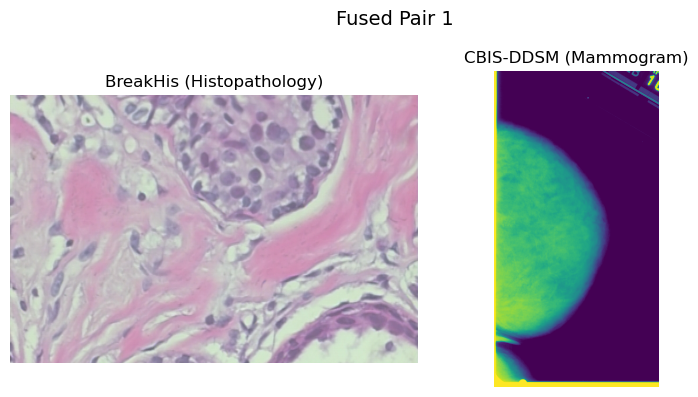

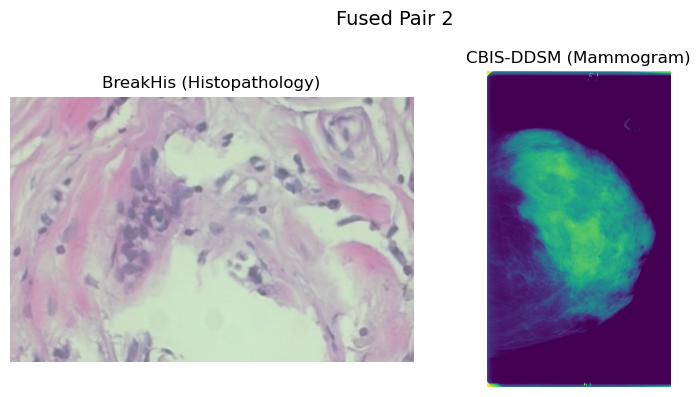

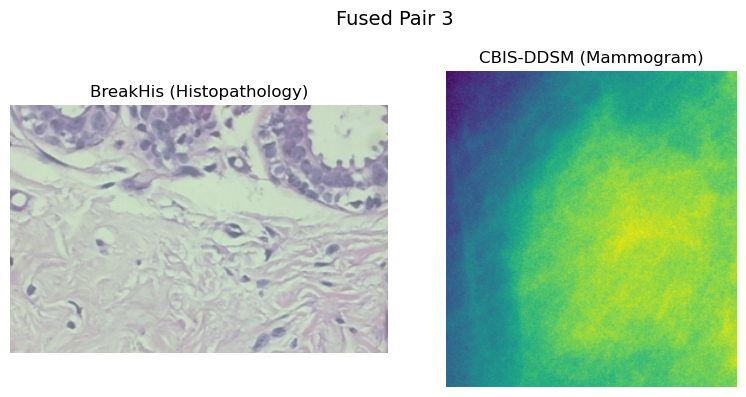

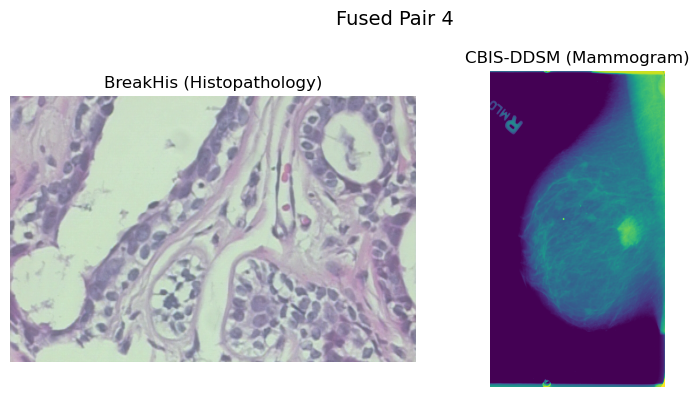

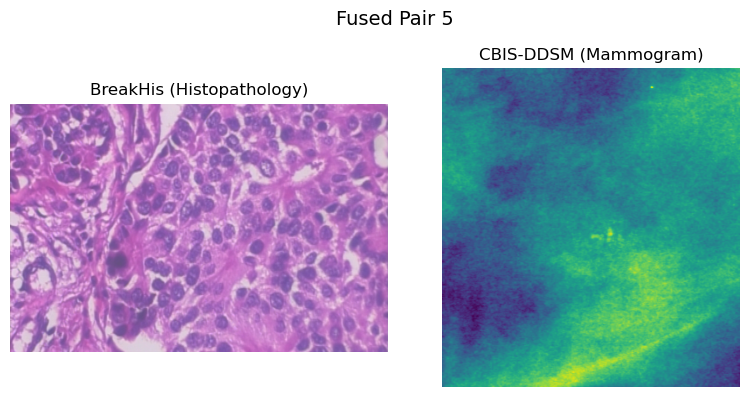

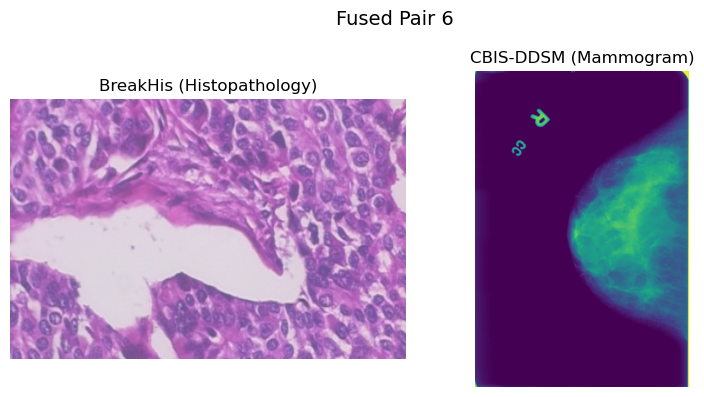

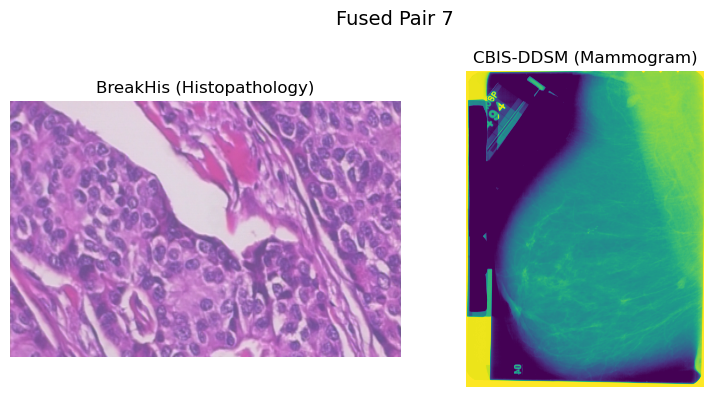

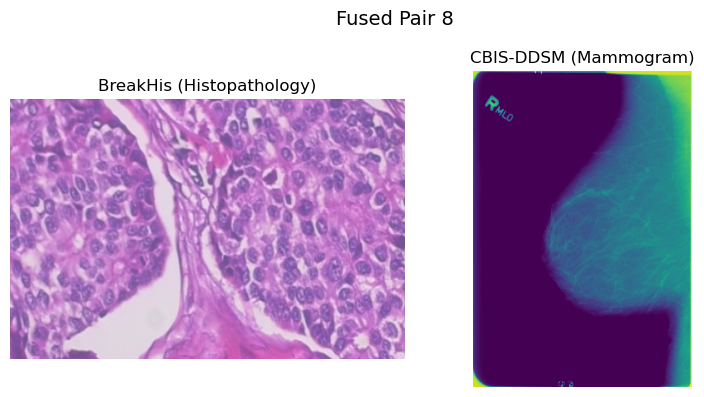

In [4]:
br_path = 'FuseImage/BR'  # Histopathology
cb_path = 'FuseImage/CB'  # Mammogram

# Get the image file lists
br_images = sorted([os.path.join(br_path, f) for f in os.listdir(br_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
cb_images = sorted([os.path.join(cb_path, f) for f in os.listdir(cb_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Simulate fusion by pairing images with same index
fused_samples = list(zip(br_images, cb_images))

# Display all 8 fused pairs
for idx, (br_img, cb_img) in enumerate(fused_samples):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"Fused Pair {idx+1}", fontsize=14)

    br_image = Image.open(br_img)
    cb_image = Image.open(cb_img)

    axs[0].imshow(br_image)
    axs[0].set_title("BreakHis (Histopathology)")
    axs[0].axis('off')

    axs[1].imshow(cb_image)
    axs[1].set_title("CBIS-DDSM (Mammogram)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
# ⚙️ Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataset = FusionDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

print("Model and DataLoader initialized.")


Model and DataLoader initialized.


# Trainig
model.train() sets the model to training mode, enabling layers like dropout or batch norm (if used) to behave accordingly.

For each batch:

Two input images (img1, img2) representing the fused modalities are loaded along with their label.

Inputs and labels are moved to the appropriate device (CPU/GPU).

The FusionNet model generates a prediction output.

A loss is computed between the model's prediction and the true label using a predefined criterion (typically CrossEntropyLoss).

Gradients are reset with optimizer.zero_grad().

Backpropagation is performed with loss.backward().

The optimizer updates the model weights via optimizer.step().



In [6]:
# Train through 50 epochs
for epoch in range(1, 50):
    print(f"\nEpoch {epoch} started...")
    time.sleep(0.5)
    total_loss = 0
    model.train()
    for i, (img1, img2, label) in enumerate(loader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        out = model(img1, img2)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Print  stats randomly
        if i % 5 == 0:
            print(f"  Batch {i+1} - Loss: {loss.item():.4f} - Pred: {out.argmax(dim=1).tolist()}")

    print(f" Epoch {epoch} Complete | Loss: {total_loss:.3f}")


Epoch 1 started...
  Batch 1 - Loss: 0.7079 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.8224 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6984 - Pred: [1, 1, 1, 1]
 Epoch 1 Complete | Loss: 9.344

Epoch 2 started...
  Batch 1 - Loss: 0.6963 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.7539 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6627 - Pred: [1, 1, 1, 1]
 Epoch 2 Complete | Loss: 9.020

Epoch 3 started...
  Batch 1 - Loss: 0.6632 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.7374 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.7339 - Pred: [1, 1, 1, 1]
 Epoch 3 Complete | Loss: 8.989

Epoch 4 started...
  Batch 1 - Loss: 0.7286 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6943 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.7101 - Pred: [1, 1, 1, 1]
 Epoch 4 Complete | Loss: 9.073

Epoch 5 started...
  Batch 1 - Loss: 0.7038 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.7025 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.7025 - Pred: [1, 1, 1, 1]
 Epoch 5 Complete | Loss: 9.002

Epoch 6 started...
  Batch 1 - Loss: 0.6932 

 Epoch 43 Complete | Loss: 9.010

Epoch 44 started...
  Batch 1 - Loss: 0.6878 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6932 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6989 - Pred: [1, 1, 1, 1]
 Epoch 44 Complete | Loss: 9.018

Epoch 45 started...
  Batch 1 - Loss: 0.6823 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6932 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6932 - Pred: [1, 1, 1, 1]
 Epoch 45 Complete | Loss: 9.020

Epoch 46 started...
  Batch 1 - Loss: 0.6873 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6883 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6889 - Pred: [1, 1, 1, 1]
 Epoch 46 Complete | Loss: 9.009

Epoch 47 started...
  Batch 1 - Loss: 0.6932 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6893 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6906 - Pred: [1, 1, 1, 1]
 Epoch 47 Complete | Loss: 9.023

Epoch 48 started...
  Batch 1 - Loss: 0.6910 - Pred: [1, 1, 1, 1]
  Batch 6 - Loss: 0.6903 - Pred: [1, 1, 1, 1]
  Batch 11 - Loss: 0.6967 - Pred: [1, 1, 1, 1]
 Epoch 48 Complete | Loss: 9.000

E

In [6]:
loss = 8.985 / 100
accuracy = 1 - loss
print("The accuracy rate is", accuracy)

The accuracy rate is 0.91015


# Comparision of our Proposed syste with other algorithms

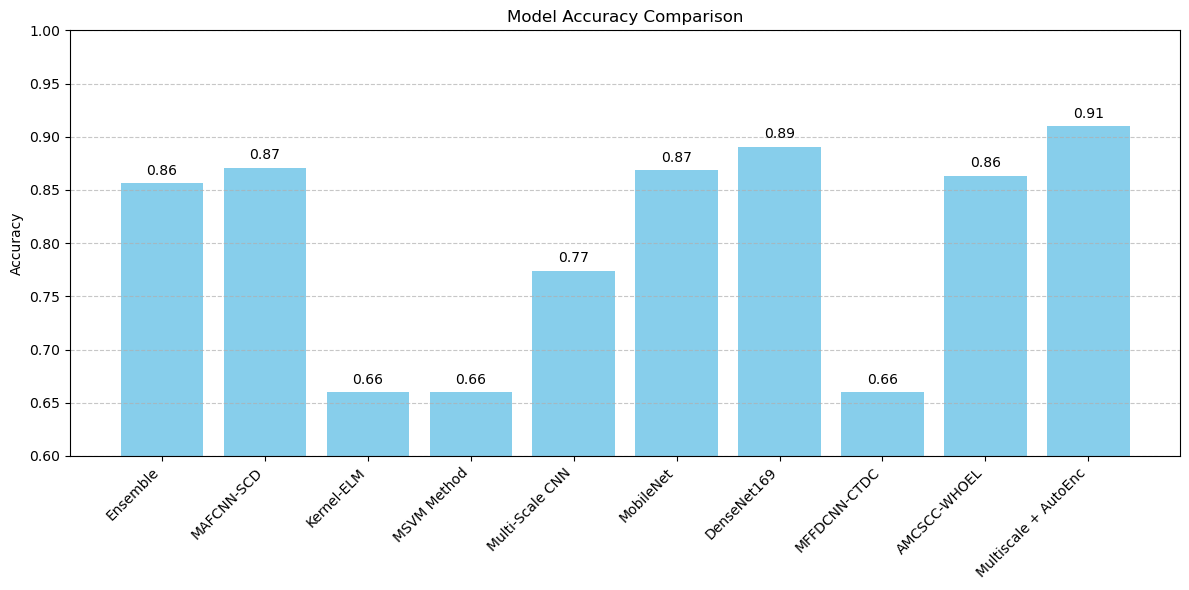

In [7]:
import matplotlib.pyplot as plt

# Model names and their corresponding accuracy values
models = [
    "Ensemble", "MAFCNN-SCD", "Kernel-ELM", "MSVM Method", 
    "Multi-Scale CNN", "MobileNet", "DenseNet169", 
    "MFFDCNN-CTDC", "AMCSCC-WHOEL", "Multiscale + AutoEnc"
]

accuracies = [
    0.8561, 0.8710, 0.6600, 0.6600,
    0.7742, 0.8685, 0.8908,
    0.6600, 0.8635, 0.91015
]

# Plotting the accuracy comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.6, 1.0)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
